## 1. Data Exploration and Preprocessing

### Data Exploration

In [6]:
import pandas as pd

#Load the dataset
df = pd.read_csv('heart_disease_prediction.csv')

#Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

#Check the shape of the dataset
print("\nDataset shape (rows, columns):", df.shape)

#Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

#Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())
print(df.iloc[:, -1].value_counts())


First 5 rows of the dataset:
   gender  age  educationLevel  currentSmoker  cigsPerDay  BPMeds  \
0       1   39             4.0              0         0.0     0.0   
1       0   46             2.0              0         0.0     0.0   
2       1   48             1.0              1        20.0     0.0   
3       0   61             3.0              1        30.0     0.0   
4       0   46             3.0              1        23.0     0.0   

   prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                0             0         0    195.0  106.0   70.0  26.97   
1                0             0         0    250.0  121.0   81.0  28.73   
2                0             0         0    245.0  127.5   80.0  25.34   
3                0             1         0    225.0  150.0   95.0  28.58   
4                0             0         0    285.0  130.0   84.0  23.10   

   heartRate  glucose  tenYearCHD  
0       80.0     77.0           0  
1       95.0     76.0      

### Data Preprocessing

Preprocessing complete. Data saved to 'processed_heart_data.csv'


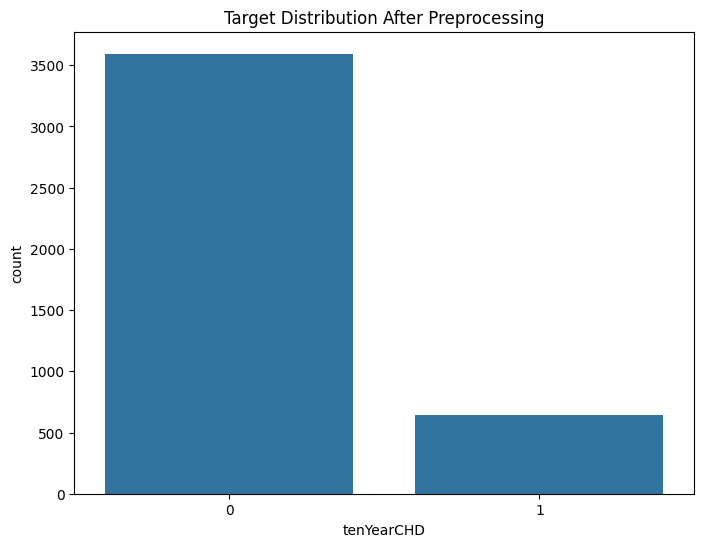

In [12]:
# STEP 1: DATA PREPROCESSING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('heart_disease_prediction.csv')

# 1. Handle missing values
continuous_vars = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']
categorical_vars = ['BPMeds', 'educationLevel']

for col in continuous_vars:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_vars:
    df[col] = df[col].fillna(df[col].mode()[0])

# 2. Handle outliers
def handle_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

outlier_cols = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in outlier_cols:
    df[col] = handle_outliers(df[col])

# 3. Save processed data
df.to_csv('processed_heart_data.csv', index=False)
print("Preprocessing complete. Data saved to 'processed_heart_data.csv'")

# 4. Diagnostic plots
plt.figure(figsize=(8, 6))
sns.countplot(x='tenYearCHD', data=df)
plt.title('Target Distribution After Preprocessing')
plt.savefig('target_distribution.png')
plt.show()

## 2. Dataset Splitting and Model Training

In [1]:
# STEP 2: FEATURE SELECTION AND MODEL TRAINING
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

# Load processed data
df = pd.read_csv('processed_heart_data.csv')

# 1. Feature selection using ANOVA F-test (alternative to p-values)
X = df.drop('tenYearCHD', axis=1)
y = df['tenYearCHD']

# Calculate F-scores and p-values
f_scores, p_values = f_classif(X, y)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_scores,
    'P_Value': p_values
}).sort_values('P_Value')

# Select features with p-value < 0.05
significant_features = feature_importance[feature_importance['P_Value'] < 0.05]['Feature'].tolist()
print(f"Selected features: {significant_features}")

# 2. Data splitting
# Split into 90% development and 10% unseen
dev_df, unseen_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['tenYearCHD']
)

# Split development data into train and test (80-20)
X_dev = dev_df[significant_features]
y_dev = dev_df['tenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=42, stratify=y_dev
)

# 3. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train logistic regression model
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

# 5. Save artifacts
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
unseen_df.to_csv('unseen_data.csv', index=False)
print("\nModel trained and artifacts saved")

# 6. Display coefficients
coeff_df = pd.DataFrame({
    'Feature': significant_features,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': np.exp(model.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

print("\nModel Coefficients and Odds Ratios:")
print(coeff_df)

Selected features: ['age', 'sysBP', 'prevalentHyp', 'diaBP', 'diabetes', 'gender', 'BPMeds', 'totChol', 'BMI', 'glucose', 'prevalentStroke', 'cigsPerDay', 'educationLevel']

Model trained and artifacts saved

Model Coefficients and Odds Ratios:
            Feature  Coefficient  Odds_Ratio
0               age     0.589580    1.803230
11       cigsPerDay     0.320697    1.378088
1             sysBP     0.243918    1.276239
5            gender     0.167686    1.182565
7           totChol     0.114083    1.120845
4          diabetes     0.113052    1.119690
10  prevalentStroke     0.085210    1.088945
2      prevalentHyp     0.085175    1.088907
6            BPMeds     0.078855    1.082048
3             diaBP     0.050195    1.051476
8               BMI     0.017540    1.017695
9           glucose     0.016006    1.016134
12   educationLevel    -0.027151    0.973214


## 3. Model Evaluation

In [4]:
# STEP 3: MODEL EVALUATION
import pandas as pd
import joblib
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns

SELECTED_FEATURES = [
    'age', 'sysBP', 'prevalentHyp', 'diaBP', 'diabetes', 'gender',
    'BPMeds', 'totChol', 'BMI', 'glucose', 'prevalentStroke',
    'cigsPerDay', 'educationLevel'
]

# Load artifacts
model = joblib.load('logistic_regression_model.pkl')
scaler = joblib.load('feature_scaler.pkl')

# Load and prepare test data
test_df = pd.read_csv('processed_heart_data.csv')
unseen_indices = pd.read_csv('unseen_data.csv').index
X_test = test_df[~test_df.index.isin(unseen_indices)].copy()
y_test = X_test['tenYearCHD']

# Select features using predefined list
X_test = X_test[SELECTED_FEATURES]

# Scale features
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred = model.predict(X_test_scaled)

# 1. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No CHD', 'CHD'],
            yticklabels=['No CHD', 'CHD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.savefig('confusion_matrix.png')
plt.close()

# 2. Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Key metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Interpretation
print("\nPERFORMANCE INTERPRETATION:")
print(f"- Model detects {recall*100:.1f}% of actual CHD cases (Recall)")
print(f"- {precision*100:.1f}% of CHD predictions are correct (Precision)")
print(f"- Overall balanced performance: {f1*100:.1f}% (F1 Score)")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      3248
           1       0.27      0.69      0.38       566

    accuracy                           0.67      3814
   macro avg       0.60      0.68      0.58      3814
weighted avg       0.83      0.67      0.72      3814

Accuracy: 0.6704
Precision: 0.2658
Recall: 0.6926
F1 Score: 0.3841

PERFORMANCE INTERPRETATION:
- Model detects 69.3% of actual CHD cases (Recall)
- 26.6% of CHD predictions are correct (Precision)
- Overall balanced performance: 38.4% (F1 Score)


## 4. Prediction on Unseen Data

In [8]:
# STEP 4: PREDICTION ON UNSEEN DATA
import pandas as pd
import joblib

# ------ Define selected features ------
SELECTED_FEATURES = [
    'age', 'sysBP', 'prevalentHyp', 'diaBP', 'diabetes', 'gender',
    'BPMeds', 'totChol', 'BMI', 'glucose', 'prevalentStroke',
    'cigsPerDay', 'educationLevel'
]

# Load artifacts
model = joblib.load('logistic_regression_model.pkl')
scaler = joblib.load('feature_scaler.pkl')
unseen_df = pd.read_csv('unseen_data.csv')

# Prepare unseen data
X_unseen = unseen_df[SELECTED_FEATURES]
y_unseen = unseen_df['tenYearCHD']
X_unseen_scaled = scaler.transform(X_unseen)

# Make predictions
y_unseen_pred = model.predict(X_unseen_scaled)
y_unseen_prob = model.predict_proba(X_unseen_scaled)[:, 1]  # Probability of CHD

# Create results dataframe
results_df = unseen_df.copy()
results_df['Predicted_CHD'] = y_unseen_pred
results_df['CHD_Probability'] = y_unseen_prob
results_df['Prediction_Correct'] = results_df['tenYearCHD'] == results_df['Predicted_CHD']

# Save results
results_df.to_csv('final_predictions.csv', index=False)

# Print results
print("Unseen Data Predictions:")
print(f"Number of cases: {len(unseen_df)}")
print(f"Actual CHD cases: {y_unseen.sum()} (1 = Yes)")
print(f"Predicted CHD cases: {y_unseen_pred.sum()} (1 = Yes)")
print(f"Accuracy: {(results_df['Prediction_Correct'].mean()*100):.1f}%")

# Create display-friendly version for sample output
display_df = results_df[['age', 'sysBP', 'glucose', 'tenYearCHD', 'Predicted_CHD', 'CHD_Probability']].copy()
display_df['Actual_CHD_Label'] = results_df['tenYearCHD'].map({0: 'No', 1: 'Yes'})
display_df['Predicted_CHD_Label'] = results_df['Predicted_CHD'].map({0: 'No', 1: 'Yes'})

print("\nSample predictions (0 = No, 1 = Yes):")
print(display_df[['age', 'sysBP', 'glucose', 'tenYearCHD', 'Actual_CHD_Label',
                 'Predicted_CHD', 'Predicted_CHD_Label', 'CHD_Probability']].head(10))

print("\nFinal predictions saved to 'final_predictions.csv'")

Unseen Data Predictions:
Number of cases: 424
Actual CHD cases: 64 (1 = Yes)
Predicted CHD cases: 164 (1 = Yes)
Accuracy: 63.2%

Sample predictions (0 = No, 1 = Yes):
   age  sysBP  glucose  tenYearCHD Actual_CHD_Label  Predicted_CHD  \
0   45  117.5     67.0           1              Yes              0   
1   41  123.0     78.0           0               No              0   
2   49  174.0     78.0           0               No              1   
3   51  122.0     78.0           0               No              1   
4   49  108.0    102.0           0               No              0   
5   40  142.0     77.0           0               No              0   
6   38  117.5     78.0           0               No              0   
7   58  132.0     70.0           1              Yes              0   
8   44  116.0     87.0           0               No              0   
9   41  107.0     87.0           0               No              0   

  Predicted_CHD_Label  CHD_Probability  
0                  No